<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!python -m spacy download en_core_web_md

import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import spacy
import seaborn as sns
from collections import Counter
import joblib
from google.colab import files

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64"

In [2]:
# Get the dev set in order to evaluate the model

from datasets import load_dataset
from huggingface_hub import login

# First : Create an account on Hugging face, and create also a token

# Connection to hugging face
login(token="")

dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')
dev_df = dataset['validation'].to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [3]:
# Loading the pretrained model
nlp = spacy.load("en_core_web_md")

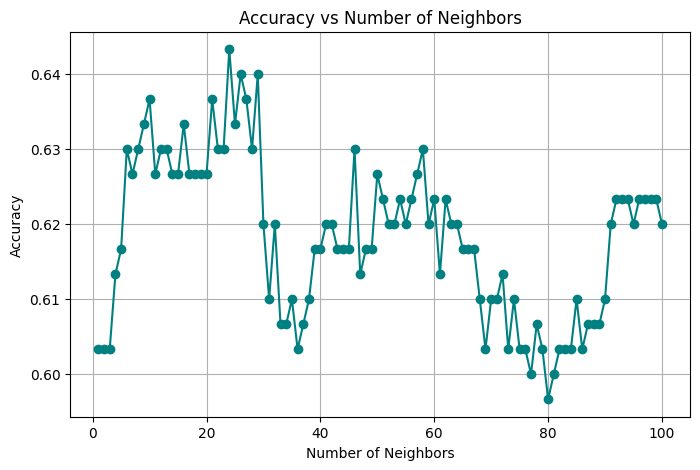

<Figure size 640x480 with 0 Axes>

In [4]:
# Exctract the texte and the label : Training
train_texts = train_df['description'].to_list()
train_labels = train_df['label'].to_list()

# Exctract the texte and the label : Dev
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label'].to_list()

# Vectorize the texts with en_core_web_md
train_vectors = np.array([nlp(text).vector for text in train_texts])
dev_vectors = np.array([nlp(text).vector for text in dev_texts])

accuracies = {}

# We test many values of k (number of neighbors in KNN)
for k in range(1, 101):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(train_vectors)

    predicted_labels = []

    for vec in dev_vectors:
        distances, indices = knn.kneighbors(vec.reshape(1, -1))

        # Get the k closest labels
        neighbor_labels = [train_labels[idx] for idx in indices[0]]

        # Choose the label (the most frequent one)
        label_counts = {}
        for label in neighbor_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]

        predicted_labels.append(majority_label)

    # Compute accuracy
    accuracy = accuracy_score(dev_labels, predicted_labels)
    accuracies[k] = accuracy

# Plot Accuracy vs Number of Neighbors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', color='teal')
plt.title("Accuracy vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
plt.savefig('Accuracy_vs_Neighbors')

In [5]:
# We get the best k : the one that gives the best accuracy
best_k = max(accuracies, key=accuracies.get)

# We train the final model, with best_k
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(train_vectors)

# We predict the labels for each item of the dev set
final_predicted_labels = []
for vec in dev_vectors:
    distances, indices = knn.kneighbors(vec.reshape(1, -1))
    neighbor_labels = [train_labels[idx] for idx in indices[0]]
    majority_label = max(set(neighbor_labels), key=neighbor_labels.count)
    final_predicted_labels.append(majority_label)

dev_df['predicted_label_KNN'] = final_predicted_labels

In [6]:
dev_df.head()

,item,name,description,type,category,subcategory,label,predicted_label_KNN
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,cultural exclusive
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,cultural representative
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,cultural representative


In [7]:
dev_df['predicted_label_KNN'].value_counts()

,count
predicted_label_KNN,
cultural agnostic,145
cultural exclusive,103
cultural representative,52


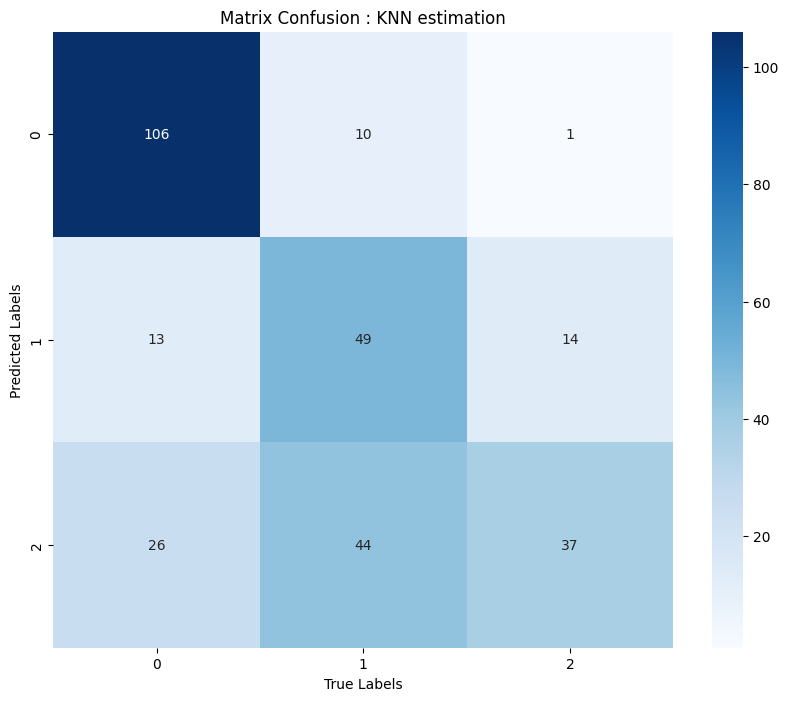

In [8]:
# Creation of the confusion matrix
y_true = dev_df['label']
y_pred = dev_df['predicted_label_KNN']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrix Confusion : KNN estimation')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [9]:
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred,average='macro')

print("Recall :", recall)
print("Precision :", precision)
print("F1-score :", f1)

Recall : 0.6321713802038446
Precision : 0.6394336998789627
F1-score : 0.6073517146315037


# Exportation

In [10]:
knn

NearestNeighbors(metric='cosine', n_neighbors=24)

In [11]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 24,
 'p': 2,
 'radius': 1.0}

In [12]:
# Save
joblib.dump(knn, 'model_KNN.joblib')

# Download
files.download('model_KNN.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>